In [14]:
import requests
import os
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [15]:
#create the colormap we want: white -> blue -> red

colors = [(1, 1, 1), (0.78, 0.84, 0.94), (0.92, 0.69, 0.65)]  # R -> G -> B
n_bins = 20  # Discretizes the interpolation into bins
cmap_name = 'white_blue_red'

# Create the colormap
cmap_wbr = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)


# Import quant table for each of the HIV-related datasets
## MIBI - Stool

In [ ]:
# import quant table from FBMN job

task_id = '0f32c284e015471c96e39bbbefe8f2d2'

#Download feature table and import
response = requests.get(f'https://gnps2.org/result?task={task_id}&viewname=quantificationdownload&resultdisplay_type=task')
directory_path = f'/directory/'

with open(directory_path + task_id + '.csv', 'wb') as f:
    f.write(response.content)
    print(f"File saved at {directory_path}")
    
ftable = pd.read_csv(os.path.join(directory_path + task_id + '.csv'), sep=',')
#just keep the column relative to the samples and feature ids.
ftable = ftable[[col for col in ftable.columns if col.endswith('Peak area') or col == 'row ID']]

#############

# import CMMC enrichment result

task_id = '9581f9d6342a45c78b935ac417337de5'

#Download CMMC enrichment table and import

response = requests.get(f'https://gnps2.org/resultfile?task={task_id}&file=nf_output/cmmc_results/cmmc_enriched_results.tsv')
directory_path = f'/directory/'

with open(directory_path + task_id + '.tsv', 'wb') as f:
    f.write(response.content)
    print(f"File saved at {directory_path}")
    
cmmc = pd.read_csv(os.path.join(directory_path + task_id + '.tsv'), sep='\t')
cmmc.columns = ['cmmc_' + col for col in cmmc.columns] #add cmmc prefix
cmmc = cmmc.rename(columns={'cmmc_query_scan': 'row ID'})  #rename to be able to merge

#merge all the annotations from the CMMC-KB to the feature table
ftable = pd.merge(ftable, cmmc, on='row ID', how='inner')


In [ ]:
def process_metabolomics_data(ftable, metadata_path, column_interest):
    """
    Process feature table and metadata, format data, filter relevant samples,
    and split into HIV+ and HIV- datasets while handling CMMC samples.

    Parameters:
    - ftable (pd.DataFrame): Feature table (DataFrame).
    - metadata_path (str): Path to the metadata file.
    - column_interest (str): The column used for grouping (e.g., 'hiv').

    Returns:
    - hiv_pos (pd.DataFrame): Formatted data for HIV+ and CMMC samples.
    - hiv_neg (pd.DataFrame): Formatted data for HIV- and CMMC samples.
    """

    # Load metadata
    metadata = pd.read_csv(metadata_path, sep="\t")

    # **Step 1: Format Feature Table**
    ftable = ftable.T.reset_index()
    ftable.columns = ftable.iloc[0]
    ftable = ftable[1:].add_prefix('MS_')
    ftable = ftable.rename(columns={'MS_row ID': 'filename'})

    # **Step 2: Clean Filenames**
    for ext in ['.mzML', '.mzXML']:
        metadata['filename'] = metadata['filename'].str.replace(ext, '', regex=False)
        ftable['filename'] = ftable['filename'].str.replace(f'{ext} Peak area', '', regex=False)

    ftable['filename'] = ftable['filename'].str.replace('_rerun', '', regex=False)

    # **Step 3: Merge with Metadata**
    ftable_merged = pd.merge(ftable, metadata[['filename', column_interest]], on='filename', how='left')
    ftable_merged = ftable_merged.fillna('not available')

    # Ensure numeric columns do not contain ".0" suffix
    ftable_merged.columns = [col.replace('.0', '') if col.endswith('.0') else col for col in ftable_merged.columns]

    # Reorganize columns, ensuring column_interest is the first column
    last_column = ftable_merged.iloc[:, -1]
    ftable_merged = pd.concat([last_column, ftable_merged.iloc[:, :-1]], axis=1)

    # Convert column of interest to string and sort
    ftable_merged[column_interest] = ftable_merged[column_interest].astype(str)
    ftable_merged = ftable_merged.sort_values(by=column_interest, ascending=True)

    # **Step 4: Keep only samples of interest**
    ftable_merged = ftable_merged[~(
        (ftable_merged[column_interest] == 'not available') &  # Condition 1: 'not available' in column_interest
        ~(ftable_merged['filename'].str.startswith('cmmc_'))  # Condition 2: 'filename' starts with 'cmmc_'
    )]

    # **Step 5: Split into HIV+ and HIV- Groups**
    def process_hiv_group(df, status):
        """
        Filters and processes either HIV+ or HIV- group.

        Parameters:
        - df (pd.DataFrame): Merged DataFrame.
        - status (str): 'HIV+' or 'HIV-'.

        Returns:
        - Processed DataFrame with summed row and filtered features.
        """
        hiv_group = df.copy()
        hiv_group = hiv_group[(hiv_group[column_interest] == status) | (hiv_group['filename'].str.startswith('cmmc_'))]

        # Identify MS_ columns
        ms_columns = [col for col in hiv_group.columns if col.startswith('MS_')]

        # Sum the values in MS_ columns for rows that do not start with 'cmmc_'
        non_cmmc_rows = hiv_group[~hiv_group['filename'].str.startswith('cmmc_')]
        sum_row = non_cmmc_rows[ms_columns].sum()

        # Create a new row with the summed values
        sum_row_df = pd.DataFrame([sum_row], columns=ms_columns)
        sum_row_df.insert(0, 'filename', 'Summed_Non_CMMC')

        # Append the summed row to the DataFrame
        hiv_group = pd.concat([hiv_group, sum_row_df], ignore_index=True)

        # Drop columns where Summed_Non_CMMC has a value of 0
        sum_row = hiv_group[hiv_group['filename'] == 'Summed_Non_CMMC']
        columns_to_drop = [col for col in ms_columns if sum_row[col].values[0] == 0]
        hiv_group = hiv_group.drop(columns=columns_to_drop)

        # **Final Step: Format Data Like pos_test and neg_test**
        hiv_group = hiv_group.T.reset_index()
        hiv_group.columns = hiv_group.iloc[1]  # Set second row as header
        hiv_group = hiv_group[2:]  # Remove previous headers
        hiv_group = hiv_group[hiv_group['filename'].str.startswith('MS_')]  # Keep MS_ rows
        hiv_group = hiv_group.rename(columns={'filename': 'scan'})  # Rename filename to scan
        hiv_group = hiv_group[['scan', 'cmmc_input_name', 'cmmc_input_source', 'cmmc_input_molecule_origin']]
        hiv_group['cmmc_input_source'] = hiv_group['cmmc_input_source'].str.split('; ')
        hiv_group = hiv_group.explode('cmmc_input_source')
        
        
        return hiv_group

    # Process HIV+ and HIV- groups with added formatting
    hiv_pos_stool = process_hiv_group(ftable_merged, 'HIV+')
    hiv_neg_stool = process_hiv_group(ftable_merged, 'HIV-')

    return hiv_pos_stool, hiv_neg_stool


metadata_path = '.../metadata_metabolomics_complete.txt'
column_interest = 'hiv'

hiv_pos_stool, hiv_neg_stool = process_metabolomics_data(ftable, metadata_path, column_interest)



# CHARTER - CSF

In [ ]:
# import quant table from FBMN job

task_id = 'afcb5cdb64c7490ca6862cafd5bbdac1'

#Download feature table and import
response = requests.get(f'https://gnps2.org/result?task={task_id}&viewname=quantificationdownload&resultdisplay_type=task')
directory_path = f'/directory/'

with open(directory_path + task_id + '.csv', 'wb') as f:
    f.write(response.content)
    print(f"File saved at {directory_path}")
    
ftable = pd.read_csv(os.path.join(directory_path + task_id + '.csv'), sep=',')
#just keep the column relative to the samples and feature ids.
ftable = ftable[[col for col in ftable.columns if col.endswith('Peak area') or col == 'row ID']]

#############

# import CMMC enrichment result

task_id = 'fecdadd0280c42cd8239d30433b54a6a'

#Download CMMC enrichment table and import

response = requests.get(f'https://gnps2.org/resultfile?task={task_id}&file=nf_output/cmmc_results/cmmc_enriched_results.tsv')
directory_path = f'/directory/'

with open(directory_path + task_id + '.tsv', 'wb') as f:
    f.write(response.content)
    print(f"File saved at {directory_path}")
    
cmmc = pd.read_csv(os.path.join(directory_path + task_id + '.tsv'), sep='\t')
cmmc.columns = ['cmmc_' + col for col in cmmc.columns] #add cmmc prefix
cmmc = cmmc.rename(columns={'cmmc_query_scan': 'row ID'})  #rename to be able to merge

#merge all the annotations from the CMMC-KB to the feature table
ftable = pd.merge(ftable, cmmc, on='row ID', how='inner')


In [ ]:
def process_metabolomics_data(ftable, metadata_path, column_interest):

    # Load metadata
    metadata = pd.read_csv(metadata_path, sep="\t", low_memory=False)

    # **Step 1: Format Feature Table**
    ftable = ftable.T.reset_index()
    ftable.columns = ftable.iloc[0]
    ftable = ftable[1:].add_prefix('MS_')
    ftable = ftable.rename(columns={'MS_row ID': 'filename'})

    # **Step 2: Clean Filenames**
    for ext in ['.mzML', '.mzXML']:
        metadata['filename'] = metadata['filename'].str.replace(ext, '', regex=False)
        ftable['filename'] = ftable['filename'].str.replace(f'{ext} Peak area', '', regex=False)

    ftable['filename'] = ftable['filename'].str.replace('_rerun', '', regex=False)

    # **Step 3: Merge with Metadata**
    ftable_merged = pd.merge(ftable, metadata[['filename', column_interest]], on='filename', how='left')
    ftable_merged = ftable_merged.fillna('not available')

    # Ensure numeric columns do not contain ".0" suffix
    ftable_merged.columns = [col.replace('.0', '') if col.endswith('.0') else col for col in ftable_merged.columns]

    # Reorganize columns, ensuring column_interest is the first column
    last_column = ftable_merged.iloc[:, -1]
    ftable_merged = pd.concat([last_column, ftable_merged.iloc[:, :-1]], axis=1)

    # Convert column of interest to string and sort
    ftable_merged[column_interest] = ftable_merged[column_interest].astype(str)
    ftable_merged = ftable_merged.sort_values(by=column_interest, ascending=True)

    # **Step 4: Keep only samples of interest**
    ftable_merged = ftable_merged[~(
        (ftable_merged[column_interest] == 'not available') &  # Condition 1: 'not available' in column_interest
        ~(ftable_merged['filename'].str.startswith('cmmc_'))  # Condition 2: 'filename' starts with 'cmmc_'
    )]
    charter_csf = ftable_merged[~ftable_merged[column_interest].isin(['QC_6mix', 'plasma_pool_QC',
                                                                        '#N/D'])]

    # **Step 5: Process HIV+ Group**
    charter_csf = charter_csf[(charter_csf[column_interest] == 'HIV+') | 
                                  (charter_csf['filename'].str.startswith('cmmc_'))]

    # Identify MS_ columns
    ms_columns = [col for col in charter_csf.columns if col.startswith('MS_')]

    # Sum the values in MS_ columns for non-CMMC samples
    non_cmmc_rows = charter_csf[~charter_csf['filename'].str.startswith('cmmc_')]
    sum_row = non_cmmc_rows[ms_columns].sum()

    # Create a new row with the summed values
    sum_row_df = pd.DataFrame([sum_row], columns=ms_columns)
    sum_row_df.insert(0, 'filename', 'Summed_Non_CMMC')

    # Append the summed row to the DataFrame
    charter_csf = pd.concat([charter_csf, sum_row_df], ignore_index=True)

    # Drop columns where Summed_Non_CMMC has a value of 0
    sum_row = charter_csf[charter_csf['filename'] == 'Summed_Non_CMMC']
    columns_to_drop = [col for col in ms_columns if sum_row[col].values[0] == 0]
    charter_csf = charter_csf.drop(columns=columns_to_drop)

    # **Final Step: Format Data**
    charter_csf = charter_csf.T.reset_index()
    charter_csf.columns = charter_csf.iloc[1]  # Set second row as header
    charter_csf = charter_csf[2:]  # Remove previous headers
    charter_csf = charter_csf[charter_csf['filename'].str.startswith('MS_')]  # Keep MS_ rows
    charter_csf = charter_csf.rename(columns={'filename': 'scan'})  # Rename filename to scan
    charter_csf = charter_csf[['scan', 'cmmc_input_name', 'cmmc_input_source', 'cmmc_input_molecule_origin']]
    charter_csf['cmmc_input_source'] = charter_csf['cmmc_input_source'].str.split('; ')
    charter_csf = charter_csf.explode('cmmc_input_source')

    return charter_csf


metadata_path = '.../metadata_CSF_CHARTER_MSV000094927.tsv'
column_interest = 'hiv_status_clean'

charter_csf = process_metabolomics_data(ftable, metadata_path, column_interest)


# CHARTER - BLOOD

In [ ]:
# import quant table from FBMN job

task_id = 'c249ae6dfbdf4dd384313d5db56c0619'

#Download feature table and import
response = requests.get(f'https://gnps2.org/result?task={task_id}&viewname=quantificationdownload&resultdisplay_type=task')
directory_path = f'/directory/'

with open(directory_path + task_id + '.csv', 'wb') as f:
    f.write(response.content)
    print(f"File saved at {directory_path}")
    
ftable = pd.read_csv(os.path.join(directory_path + task_id + '.csv'), sep=',')
#just keep the column relative to the samples and feature ids.
ftable = ftable[[col for col in ftable.columns if col.endswith('Peak area') or col == 'row ID']]

#############

# import CMMC enrichment result

task_id = '54a9d3588f624be48fd7bdc7953951e9'

#Download CMMC enrichment table and import

response = requests.get(f'https://gnps2.org/resultfile?task={task_id}&file=nf_output/cmmc_results/cmmc_enriched_results.tsv')
directory_path = f'/directory/'

with open(directory_path + task_id + '.tsv', 'wb') as f:
    f.write(response.content)
    print(f"File saved at {directory_path}")
    
cmmc = pd.read_csv(os.path.join(directory_path + task_id + '.tsv'), sep='\t')
cmmc.columns = ['cmmc_' + col for col in cmmc.columns] #add cmmc prefix
cmmc = cmmc.rename(columns={'cmmc_query_scan': 'row ID'})  #rename to be able to merge

#merge all the annotations from the CMMC-KB to the feature table
ftable = pd.merge(ftable, cmmc, on='row ID', how='inner')


In [ ]:
def process_metabolomics_data(ftable, metadata_path, column_interest):

    # Load metadata
    metadata = pd.read_csv(metadata_path, sep="\t", low_memory=False)

    # **Step 1: Format Feature Table**
    ftable = ftable.T.reset_index()
    ftable.columns = ftable.iloc[0]
    ftable = ftable[1:].add_prefix('MS_')
    ftable = ftable.rename(columns={'MS_row ID': 'filename'})

    # **Step 2: Clean Filenames**
    for ext in ['.mzML', '.mzXML']:
        metadata['filename'] = metadata['filename'].str.replace(ext, '', regex=False)
        ftable['filename'] = ftable['filename'].str.replace(f'{ext} Peak area', '', regex=False)

    ftable['filename'] = ftable['filename'].str.replace('_rerun', '', regex=False)

    # **Step 3: Merge with Metadata**
    ftable_merged = pd.merge(ftable, metadata[['filename', column_interest]], on='filename', how='left')
    ftable_merged = ftable_merged.fillna('not available')

    # Ensure numeric columns do not contain ".0" suffix
    ftable_merged.columns = [col.replace('.0', '') if col.endswith('.0') else col for col in ftable_merged.columns]

    # Reorganize columns, ensuring column_interest is the first column
    last_column = ftable_merged.iloc[:, -1]
    ftable_merged = pd.concat([last_column, ftable_merged.iloc[:, :-1]], axis=1)

    # Convert column of interest to string and sort
    ftable_merged[column_interest] = ftable_merged[column_interest].astype(str)
    ftable_merged = ftable_merged.sort_values(by=column_interest, ascending=True)

    # **Step 4: Keep only samples of interest**
    ftable_merged = ftable_merged[~(
        (ftable_merged[column_interest] == 'not available') &  # Condition 1: 'not available' in column_interest
        ~(ftable_merged['filename'].str.startswith('cmmc_'))  # Condition 2: 'filename' starts with 'cmmc_'
    )]
    charter_blood = ftable_merged[~ftable_merged[column_interest].isin(['QC_6mix', 'plasma_pool_QC',
                                                                        '#N/D'])]

    # **Step 5: Process HIV+ Group**
    charter_blood = charter_blood[(charter_blood[column_interest] == 'HIV+') | 
                                  (charter_blood['filename'].str.startswith('cmmc_'))]

    # Identify MS_ columns
    ms_columns = [col for col in charter_blood.columns if col.startswith('MS_')]

    # Sum the values in MS_ columns for non-CMMC samples
    non_cmmc_rows = charter_blood[~charter_blood['filename'].str.startswith('cmmc_')]
    sum_row = non_cmmc_rows[ms_columns].sum()

    # Create a new row with the summed values
    sum_row_df = pd.DataFrame([sum_row], columns=ms_columns)
    sum_row_df.insert(0, 'filename', 'Summed_Non_CMMC')

    # Append the summed row to the DataFrame
    charter_blood = pd.concat([charter_blood, sum_row_df], ignore_index=True)

    # Drop columns where Summed_Non_CMMC has a value of 0
    sum_row = charter_blood[charter_blood['filename'] == 'Summed_Non_CMMC']
    columns_to_drop = [col for col in ms_columns if sum_row[col].values[0] == 0]
    charter_blood = charter_blood.drop(columns=columns_to_drop)

    # **Final Step: Format Data**
    charter_blood = charter_blood.T.reset_index()
    charter_blood.columns = charter_blood.iloc[1]  # Set second row as header
    charter_blood = charter_blood[2:]  # Remove previous headers
    charter_blood = charter_blood[charter_blood['filename'].str.startswith('MS_')]  # Keep MS_ rows
    charter_blood = charter_blood.rename(columns={'filename': 'scan'})  # Rename filename to scan
    charter_blood = charter_blood[['scan', 'cmmc_input_name', 'cmmc_input_source', 'cmmc_input_molecule_origin']]
    charter_blood['cmmc_input_source'] = charter_blood['cmmc_input_source'].str.split('; ')
    charter_blood = charter_blood.explode('cmmc_input_source')

    return charter_blood


metadata_path = '.../metadata_metabolomics_PLASMA_MSV000095567.txt'
column_interest = 'hiv_status_clean'

charter_blood = process_metabolomics_data(ftable, metadata_path, column_interest)


# Compare CMMC results

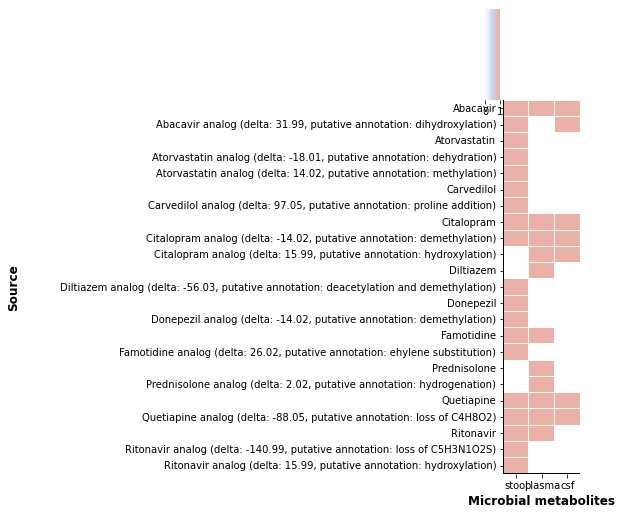

In [ ]:
### heatmap of only drugs that have analogs

### HEATMAP - DRUGS AND MICROBIAL METABOLISM OF DRUGS

hiv_pos_stool = hiv_pos_stool[hiv_pos_stool['cmmc_input_source'].str.contains('Microbial|Drug', case=False, na=False)]
charter_csf = charter_csf[charter_csf['cmmc_input_source'].str.contains('Microbial|Drug', case=False, na=False)]
charter_blood = charter_blood[charter_blood['cmmc_input_source'].str.contains('Microbial|Drug', case=False, na=False)]

hiv_pos_stool['source'] = 'stool'
charter_csf['source'] = 'csf'
charter_blood['source'] = 'plasma'

combined_df = pd.concat([hiv_pos_stool, charter_csf, charter_blood], ignore_index=True)
combined_df = combined_df.sort_index()

#create binary pivot table
combined_df_filtered = combined_df[combined_df['cmmc_input_molecule_origin'].str.contains('Microbial metabolism of drugs|Drug', case=False, na=False)]
pivot_table = combined_df_filtered[['cmmc_input_name', 'source']]
pivot_table = pivot_table.pivot_table(index='cmmc_input_name', columns='source', aggfunc=lambda x:1, fill_value=0)
pivot_table = pivot_table.T


# Identify drug columns (without "analog")
drug_columns = [col for col in pivot_table.columns if "analog" not in col]

# Identify analog columns (contain "analog")
analog_columns = [col for col in pivot_table.columns if "analog" in col]

# Find drugs that have at least one corresponding analog
valid_drugs = {drug for drug in drug_columns if any(drug in analog for analog in analog_columns)}

# Filter columns to keep only valid drugs and their corresponding analogs
filtered_columns = [col for col in pivot_table.columns if col in valid_drugs or any(drug in col for drug in valid_drugs)]

# Create a new DataFrame with filtered columns
pivot_table_filtered = pivot_table[filtered_columns]
pivot_table_filtered = pivot_table_filtered.T
column_order = ['stool', 'plasma', 'csf']
pivot_table_filtered = pivot_table_filtered[column_order]

fig = sns.clustermap(
    pivot_table_filtered, 
    metric='jaccard',
    cmap=cmap_wbr,
    col_cluster=False, 
    row_cluster=False,
#     yticklabels=log_transformed_data_with_annotations[xaxis],
    linewidths=0.05,
    linecolor = 'white',
    xticklabels=1,
    yticklabels=1,
    cbar_kws={'orientation': 'horizontal'}
)

fig.ax_heatmap.set_xlabel('Microbial metabolites', fontsize=12, weight='bold')
fig.ax_heatmap.set_ylabel('Source', fontsize=12, weight='bold', labelpad=40)

fig.ax_heatmap.yaxis.set_label_position("left")
fig.ax_heatmap.yaxis.set_ticks_position("left")

# Show all Y labels
fig.ax_heatmap.set_yticklabels(fig.ax_heatmap.get_ymajorticklabels(), fontsize=10)

line_count = len(pivot_table_filtered)

# Add an x-axis line at the bottom of the heatmap
fig.ax_heatmap.axhline(y=line_count, color='black', linewidth=2)
# Add a y-axis line on the left side of the heatmap
fig.ax_heatmap.axvline(x=0, color='black', linewidth=2)

fig.ax_heatmap.yaxis.tick_left()

#Resize figure
plt.gcf().set_size_inches(4, 7)

# plt.savefig('.../heatmap_drugs_hiv.pdf')

plt.show()
